In [1]:
import numpy as np
import keras
import scipy
import os
from IPython.display import Audio
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import random
import pylab
import wave
import sounddevice as sd
import scipy.io.wavfile as wavf

OUTPUT_DIR = "data/synthesized"
TRAINING_DIR = "data/training"
VOICE_MS = 1500
SAMPLE_MS = 10000
STRIDE = 4
FILTER_SIZE = 15

C:\Users\stigb\machine_learning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print(tf.test.gpu_device_name())
device_lib.list_local_devices()

/device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5250797954398520506, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 117414297
 locality {
   bus_id: 1
 }
 incarnation: 13411009660569184027
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1"]

In [3]:
data_dir = os.walk("data/background")
for i in data_dir:
    folders = i[1]
    break
background_noise_files = []
files = []
for i in folders:
    folder_path = os.path.join("data/background", i)
    for f in os.listdir(folder_path):
        files.append(os.path.join(folder_path, f))

In [4]:
def graph_spectrogram_v1(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
    #pylab.figure(num=None, figsize=(19, 12))
    #print(frame_rate) # 44100
    x = pylab.specgram(sound_info, Fs=frame_rate)
    pylab.ioff()
    #pylab.savefig('spectrogram.png')
    return x[0]
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx
def get_wav_info_v1(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [5]:
def get_random_startpoint_in_clip(clip):
    clip_length = len(clip)
    start_point = random.randint(0, clip_length - 10 * 1000)
    return start_point

def create_random_audio(audio_files, file_name):
    file_id = random.randint(0, len(audio_files)-1)
    
    background_noise = AudioSegment.from_wav(files[file_id])
    background_noise = background_noise.set_frame_rate(44100)
    start_point = get_random_startpoint_in_clip(background_noise)
    
    background_noise[start_point: start_point + (10 * 1000)].export(file_name, format="wav")
    return AudioSegment.from_file(file_name)
create_random_audio(files, "data/test.wav")
Audio("data/test.wav")

In [6]:
spec = graph_spectrogram("data/test.wav")
FREQS, SPEC_SIZE = np.shape(spec)

OUTPUT_LENGTH = round(((SPEC_SIZE + FILTER_SIZE) / STRIDE) + 1)
print(OUTPUT_LENGTH)


1382


In [7]:
def record_sound(filename):
    duration = 1.5  # seconds
    fs = 44100
    myrecording = sd.rec(int(duration * fs), samplerate=fs, channels=2, blocking=True)
    wavf.write(filename, fs, myrecording)
    return myrecording


In [8]:


#record_sound("data/dev/neg1.wav")


In [9]:
pos_voices = [f for f in os.listdir("data/voices/pos/")]
neg_voices = [f for f in os.listdir("data/voices/neg/")]
def get_random_voice(positive_sample):
    pos_voice_index = random.randint(3, len(pos_voices))
    neg_voice_index = random.randint(1, len(neg_voices))
    path = "data/voices/pos/pos%s.wav" % pos_voice_index if positive_sample else "data/voices/neg/neg%s.wav" % neg_voice_index
    voice = AudioSegment.from_file(path)
    voice = voice[200:]
    return voice

In [64]:
OUTPUT_LENGTH = 1375 # convert dim from raw spectogram to dim after 1D CONV

def is_overlap(position, prev_positions):
    pos_start = position
    pos_stop = position + VOICE_MS
    for p in prev_positions:
        prev_start = p
        prev_stop = p + VOICE_MS
        if pos_start <= prev_stop and pos_start >= prev_start or pos_stop >= prev_start and pos_stop <= prev_stop:
            return True
    return False
prev_positions = []
def add_voice_to_background(file_name, background_noise, positive):
    start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    while is_overlap(start_position, prev_positions):
        start_position = random.randint(0, SAMPLE_MS - VOICE_MS)
    #print(start_position)
    prev_positions.append(start_position)
    voice = get_random_voice(positive)
    res = background_noise.overlay(voice, position=start_position)
    res.export(file_name, format="wav")
    return (res, (start_position + VOICE_MS))


def create_training_sample(index):
    y = np.zeros(OUTPUT_LENGTH)
    file_name = "data/training/temp.wav"
    background_noise = create_random_audio(files, "data/test.wav")
    pos_samples = random.randint(2,3)
    neg_samples = 1
    for i in range(pos_samples):
        background_noise, ends = add_voice_to_background(file_name, background_noise, True)
        ends = round((ends / 10000) * OUTPUT_LENGTH) # scale to output
        tends = min(OUTPUT_LENGTH, ends + 50)
        y[ends:tends] = 1
        #print(ends)
    for i in range(neg_samples):
        background_noise, ends = add_voice_to_background(file_name, background_noise, False)
        #print(ends)
    x = graph_spectrogram("data/training/temp.wav")
    print(np.shape(x))
    np.save("%s\\y%d.npy" % (TRAINING_DIR, index), y)
    np.save("%s\\x%d.npy" % (TRAINING_DIR, index), x.T)
    return (x,y)


x,y  = create_training_sample(1)
Audio("data/training/temp.wav")

(101, 5511)


(101, 5511)
(1375,)


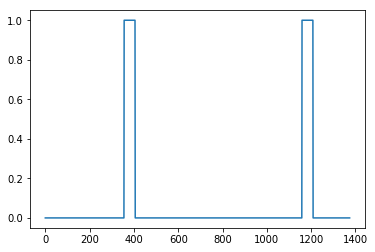

In [65]:
print(np.shape(x))
print(np.shape(y))
plt.close()
plt.plot(y)
plt.show()


In [12]:
print(TRAINING_DIR)

data/training


In [67]:
start_point = 319
for i in range(start_point, 500):
    prev_positions = []
    create_training_sample(i)
    print(i)

(101, 5511)
319
(101, 5511)
320
(101, 5511)
321
(101, 5511)
322
(101, 5511)
323
(101, 5511)
324
(101, 5511)
325
(101, 5511)
326
(101, 5511)
327
(101, 5511)
328
(101, 5511)
329
(101, 5511)
330
(101, 5511)
331
(101, 5511)
332
(101, 5511)
333
(101, 5511)
334
(101, 5511)
335
(101, 5511)
336
(101, 5511)
337
(101, 5511)
338
(101, 5511)
339
(101, 5511)
340
(101, 5511)
341
(101, 5511)
342
(101, 5511)
343
(101, 5511)
344
(101, 5511)
345
(101, 5511)
346
(101, 5511)
347
(101, 5511)
348
(101, 5511)
349
(101, 5511)
350
(101, 5511)
351
(101, 5511)
352
(101, 5511)
353
(101, 5511)
354
(101, 5511)
355
(101, 5511)
356
(101, 5511)
357
(101, 5511)
358
(101, 5511)
359
(101, 5511)
360
(101, 5511)
361
(101, 5511)
362
(101, 5511)
363
(101, 5511)
364
(101, 5511)
365
(101, 5511)
366
(101, 5511)
367
(101, 5511)
368
(101, 5511)
369
(101, 5511)
370
(101, 5511)
371
(101, 5511)
372
(101, 5511)
373
(101, 5511)
374
(101, 5511)
375
(101, 5511)
376
(101, 5511)
377
(101, 5511)
378
(101, 5511)
379
(101, 5511)
380
(101, 55

In [13]:
x_test = np.load("data/training/x1.npy")
y_test = np.load("data/training/y1.npy")
print(x_test.shape)
print(y_test.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'data/training/x1.npy'

In [82]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Dropout, Activation, TimeDistributed, Dense, GRU
from keras.optimizers import Adam
def model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(.5)(X)
    X = GRU(128, return_sequences = True)(X)
    X = Dropout(.5)(X)
    X = BatchNormalization()(X)
    X = GRU(128, return_sequences = True)(X)
    X = Dropout(.5)(X)
    X = BatchNormalization()(X)
    X = Dropout(.5)(X)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    return Model(inputs = X_input, outputs = X)
model = model(input_shape = (5511, 101))


In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1375, 128)         0         
__________

In [84]:
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [69]:
def load_subset(startp, stopp):
    X=[]
    Y=[]
    for i in range(startp, stopp):
        X.append(np.load("%s\\x%d.npy" % (TRAINING_DIR, i)))
        Y.append(np.load("%s\\y%d.npy" % (TRAINING_DIR, i)))
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.reshape(((stopp-startp), 1375, 1))
    return X, Y

In [70]:
X, Y = load_subset(0, 500)
np.shape(Y[0])
print(np.shape(Y))
plt.plot(Y[0,:,0])

(500, 1375, 1)


In [ ]:
print(Y[0,:,0])

In [85]:
from keras.callbacks import ModelCheckpoint
import h5py

filepath="data/weights.best.hdf5"
model.load_weights(filepath)
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

#X, Y = load_subset(i*500, (i*500)+500)
model.fit(X, Y, batch_size = 250, epochs=20000, callbacks=callbacks_list)
#model.fit(X, Y, batch_size = 32, epochs=100)

Epoch 1/20000
500/500 [==============================] - 14s 28ms/step - loss: 0.2770 - acc: 0.9078
Epoch 2/20000
500/500 [==============================] - 10s 20ms/step - loss: 0.2350 - acc: 0.9178
Epoch 3/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1988 - acc: 0.9273
Epoch 4/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1912 - acc: 0.9297
Epoch 5/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1807 - acc: 0.9318
Epoch 6/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1776 - acc: 0.9322
Epoch 7/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1762 - acc: 0.9320
Epoch 8/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1726 - acc: 0.9321
Epoch 9/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1672 - acc: 0.9344
Epoch 10/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1684 - acc: 0.9352
Epoch 1

Epoch 37/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1190 - acc: 0.9550
Epoch 38/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1197 - acc: 0.9543
Epoch 39/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1203 - acc: 0.9540
Epoch 40/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1191 - acc: 0.9548
Epoch 41/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1198 - acc: 0.9538
Epoch 42/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1173 - acc: 0.9550
Epoch 43/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1182 - acc: 0.9546
Epoch 44/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1185 - acc: 0.9548
Epoch 45/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1163 - acc: 0.9563
Epoch 46/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1185 - acc: 0.9550


Epoch 73/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1135 - acc: 0.9570
Epoch 74/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1128 - acc: 0.9571
Epoch 75/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1140 - acc: 0.9565
Epoch 76/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1141 - acc: 0.9566
Epoch 77/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1141 - acc: 0.9568
Epoch 78/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1113 - acc: 0.9581
Epoch 79/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1119 - acc: 0.9578
Epoch 80/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1104 - acc: 0.9576
Epoch 81/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1117 - acc: 0.9575
Epoch 82/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1108 - acc: 0.9583


Epoch 109/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1096 - acc: 0.9588
Epoch 110/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1071 - acc: 0.9597
Epoch 111/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1078 - acc: 0.9595
Epoch 112/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1097 - acc: 0.9591
Epoch 113/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1096 - acc: 0.9587
Epoch 114/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1105 - acc: 0.9583
Epoch 115/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1092 - acc: 0.9586
Epoch 116/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1085 - acc: 0.9591
Epoch 117/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1053 - acc: 0.9605
Epoch 118/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1090 - ac

500/500 [==============================] - 9s 17ms/step - loss: 0.1058 - acc: 0.9600
Epoch 145/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1062 - acc: 0.9599
Epoch 146/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1063 - acc: 0.9600
Epoch 147/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1040 - acc: 0.9609
Epoch 148/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1048 - acc: 0.9607
Epoch 149/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1054 - acc: 0.9606
Epoch 150/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1056 - acc: 0.9603
Epoch 151/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1054 - acc: 0.9604
Epoch 152/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1054 - acc: 0.9608
Epoch 153/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1059 - acc: 0.9608
Epoch 

500/500 [==============================] - 9s 18ms/step - loss: 0.1051 - acc: 0.9606
Epoch 180/20000
500/500 [==============================] - 10s 19ms/step - loss: 0.1034 - acc: 0.9614
Epoch 181/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1031 - acc: 0.9613
Epoch 182/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1051 - acc: 0.9608
Epoch 183/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1040 - acc: 0.9611
Epoch 184/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1034 - acc: 0.9615
Epoch 185/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1059 - acc: 0.9607
Epoch 186/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1063 - acc: 0.9602
Epoch 187/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1038 - acc: 0.9612
Epoch 188/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1036 - acc: 0.9610
Epoch

500/500 [==============================] - 9s 18ms/step - loss: 0.1020 - acc: 0.9620
Epoch 215/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1028 - acc: 0.9619
Epoch 216/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1026 - acc: 0.9617
Epoch 217/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1019 - acc: 0.9623
Epoch 218/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1007 - acc: 0.9628
Epoch 219/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1036 - acc: 0.9618
Epoch 220/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1028 - acc: 0.9619
Epoch 221/20000
500/500 [==============================] - 9s 17ms/step - loss: 0.1018 - acc: 0.9620
Epoch 222/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1011 - acc: 0.9627
Epoch 223/20000
500/500 [==============================] - 9s 18ms/step - loss: 0.1001 - acc: 0.9629
Epoch 

KeyboardInterrupt: 

/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
/home/stig/PycharmProjects/triggerword/venv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7550: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(1, 6889, 129)


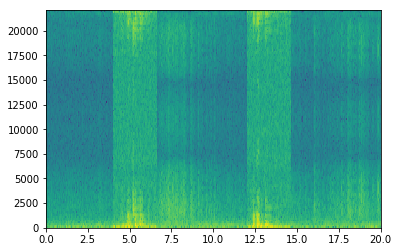

In [41]:
background = AudioSegment.from_wav("data/background/living/ch01.wav")
voice = AudioSegment.from_wav("data/dev/pos1.wav")
neg = AudioSegment.from_wav("data/dev/neg1.wav")
background = background[:10000]
background = background.overlay(voice[200:], position=2000)
background = background.overlay(neg[200:], position=6000)
background.export("data/dev.wav", format="wav")
inp = graph_spectrogram("data/dev.wav")
inp = inp.T
inp=inp.reshape((1,6889,129))
print(np.shape(inp))

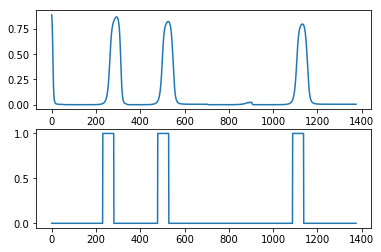

In [95]:
def plot_item():
    itemid=309
    x = X[itemid]
    y = Y[itemid]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    plt.subplot(211)
    plt.plot(prediction[0,:,0])
    plt.subplot(212)
    plt.plot(y)
    plt.show()
plot_item()

I had to update the training set to include more positive samples. otherwise the ratio negative/positive is waay to low. It is already a sparse dataset. 
I hope this will force the model to better match positive examples


In [ ]:
I 